# Surgery pipeline with TRVAE - comparison between zero-, one-shot and full query training

In [1]:
import scib

In [2]:
import os
import timeit
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
Global seed set to 0
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas. We strongly suggest to use earlystopping to avoid over-fitting. The best earlystopping criteria is the 'val_unweighted_loss' for TRVAE.

In [5]:
condition_key = 'batch'
cell_type_key = 'final_annotation'
target_conditions = ["Oetjen_A","Sun_sample1_CS"]
#Min number cells batch
# target_conditions = ['Villani']


trvae_epochs = 500
alpha_epoch = 200 
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [6]:
url = 'https://figshare.com/ndownloader/files/25717328'
output = 'Immune_ALL_human.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://figshare.com/ndownloader/files/25717328
To: /home/icb/aleksandra.topalova/scarches/notebooks/Immune_ALL_human.h5ad
100%|██████████| 2.06G/2.06G [00:34<00:00, 59.3MB/s]


'Immune_ALL_human.h5ad'

In [7]:
adata = sc.read('Immune_ALL_human.h5ad')

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/batch' was written without encoding metadata.
  categories = read_elem(categories_dset)
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/batch' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:584: 

In [8]:
min_batch = adata.obs.groupby(['batch'])['batch'].count()
min_batch

batch
10X               10727
Freytag            3347
Oetjen_A           2586
Oetjen_P           3265
Oetjen_U           3730
Sun_sample1_CS     1725
Sun_sample2_KC     2281
Sun_sample3_TB     2403
Sun_sample4_TC     2420
Villani            1022
Name: batch, dtype: int64

In [9]:
adata.obs.head(3)

batch chemistry data_type  dpt_pseudotime  \
index                                                                       
AAACCTGCAGCGAACA-1-Oetjen_A  Oetjen_A    v2_10X       UMI             NaN   
AAACCTGCATGTCCTC-1-Oetjen_A  Oetjen_A    v2_10X       UMI             NaN   
AAACCTGGTCGACTGC-1-Oetjen_A  Oetjen_A    v2_10X       UMI             NaN   

                            final_annotation   mt_frac  n_counts  n_genes  \
index                                                                       
AAACCTGCAGCGAACA-1-Oetjen_A  CD16+ Monocytes  0.047970    6379.0   1862.0   
AAACCTGCATGTCCTC-1-Oetjen_A     CD4+ T cells  0.024928    4172.0   1082.0   
AAACCTGGTCGACTGC-1-Oetjen_A  CD14+ Monocytes  0.051907    6608.0   1618.0   

                            sample_ID  size_factors species   study  \
index                                                                 
AAACCTGCAGCGAACA-1-Oetjen_A         0      0.957719   Human  Oetjen   
AAACCTGCATGTCCTC-1-Oetjen_A         0      0.425532   Human  Oetjen   
AAACCTGGTCGACTGC-1-Oetjen_A         0      0.773111   Human  Oetjen   

                                  tissue  
index                                     
AAACCTGCAGCGAACA-1-Oetjen_A  Bone_Marrow  
AAACCTGCATGTCCTC-1-Oetjen_A  Bone_Marrow  
AAACCTGGTCGACTGC-1-Oetjen_A  Bone_Marrow

In [10]:
adata.X = adata.layers["counts"].copy()

This line makes sure that count data is in the adata.X. Remember that count data in adata.X is necessary when using "nb" or "zinb" loss. However, when using trVAE with MSE loss normalized data is necessary in adata.X

In [11]:
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
source_conditions = source_adata.obs[condition_key].unique().tolist()

In [13]:
target_adata.obs['ref_or_query'] = 'query'
source_adata.obs['ref_or_query'] = 'ref'

In [14]:
source_adata

AnnData object with n_obs × n_vars = 29195 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query'
    layers: 'counts'

In [15]:
target_adata

AnnData object with n_obs × n_vars = 4311 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query'
    layers: 'counts'

In [16]:
source_adata.raw = source_adata
sc.pp.normalize_total(source_adata)
sc.pp.log1p(source_adata)

In [17]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [18]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

In [19]:
source_adata

AnnData object with n_obs × n_vars = 29195 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

### Create TRVAE model and train it on reference dataset

Create the trVAE model instance with NB loss as default. Insert "recon_loss='mse'," or "recon_loss='zinb'," to change the reconstruction loss.

In [20]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 8
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 8
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [21]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=alpha_epoch,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

 |█████---------------| 25.0%  - val_loss: 902.7000042459 - val_recon_loss: 850.4293478261 - val_kl_loss: 21.3021470775 - val_mmd_loss: 39.06333923344
ADJUSTED LR
 |█████---------------| 28.8%  - val_loss: 907.0373853601 - val_recon_loss: 851.2496815557 - val_kl_loss: 20.3127462138 - val_mmd_loss: 41.2640908283
ADJUSTED LR
 |██████--------------| 30.2%  - val_loss: 904.5756517493 - val_recon_loss: 849.8593511167 - val_kl_loss: 20.1128557454 - val_mmd_loss: 39.6316525832
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 150


### Create anndata file of latent representation and compute UMAP

In [22]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()
adata_latent.obs['ref_or_query'] = source_adata.obs['ref_or_query'].tolist()

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


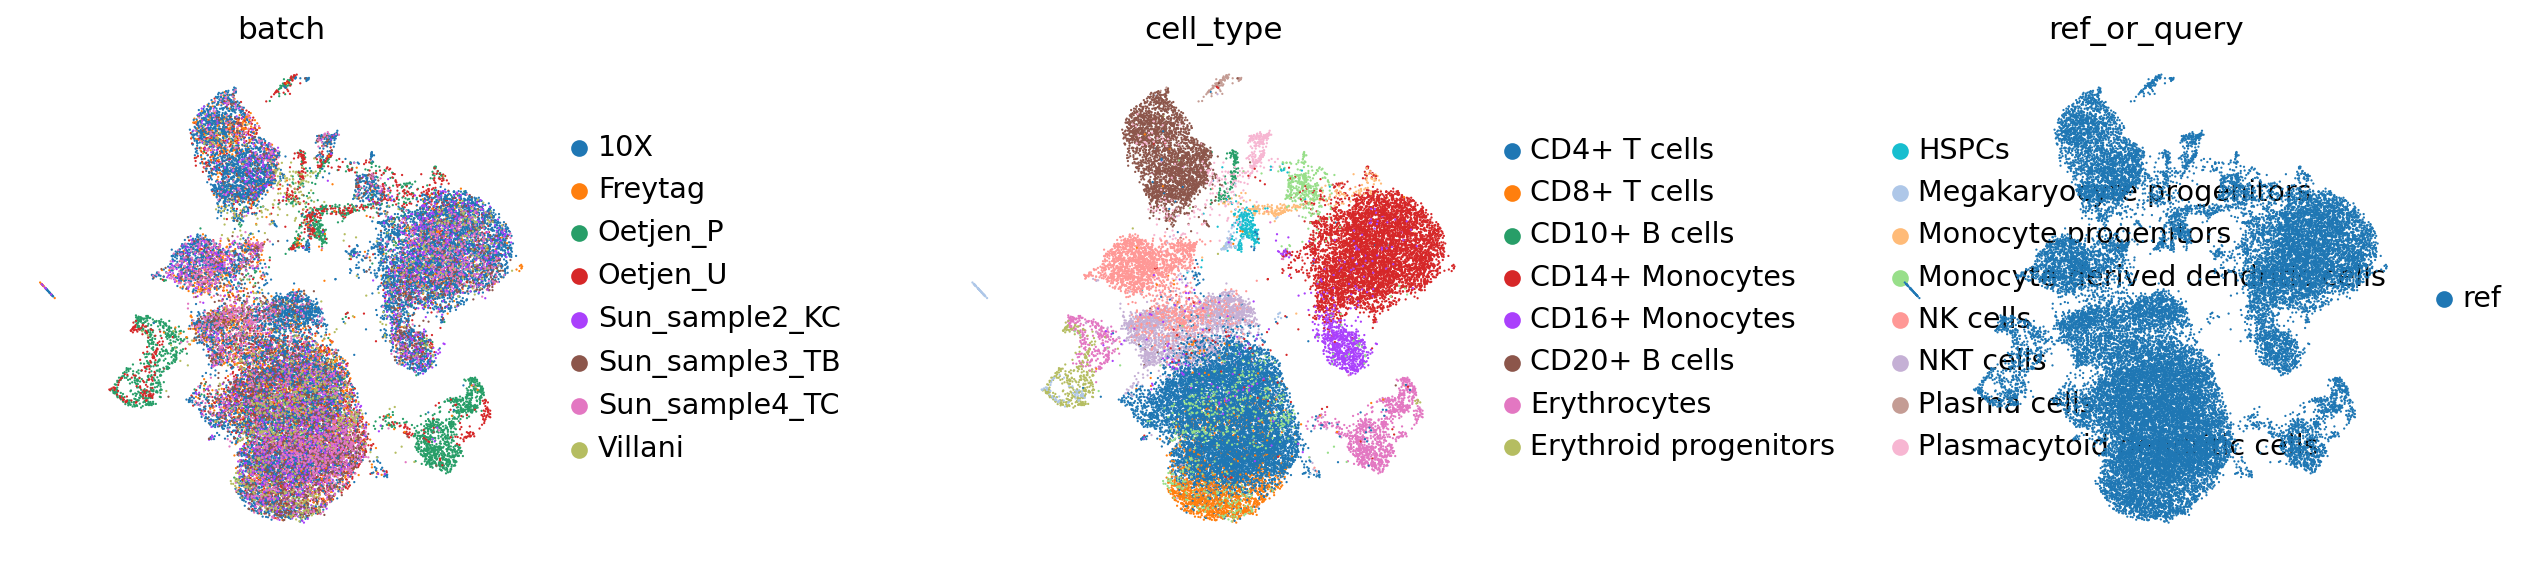

In [23]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type', 'ref_or_query'],
           frameon=False,
           wspace=0.6,
           )

After pretraining the model can be saved for later use

In [24]:
ref_path = 'reference_model/'
trvae.save(ref_path, overwrite=True)

In [25]:
target_adata = target_adata[:, source_adata.var_names]
target_adata

View of AnnData object with n_obs × n_vars = 4311 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query'
    layers: 'counts'

### Perform surgery on reference model and train on query dataset using one-shot mapping

In [26]:
start_time_1 = timeit.default_timer()

query_model_one = trvae.one_shot_surgery(target_adata, ref_path, copy=False, pretrain = 1)

time_one = timeit.default_timer() - start_time_1
print(f'Executed in {time_one} seconds') 

AnnData object with n_obs × n_vars = 4311 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query', '_original_batch'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 8
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 8
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 

Device cpu
Processing original category: Oetjen_A n_obs: 2586
  processing Oetjen_P
  processing Oetjen_U
  processing Freytag
  processing 10X
  processing Sun_sample2_KC
  processing Sun_sample3_TB
  processing Sun_sample4_TC
  processing Villani
Processing original category: Sun_sample1_CS n_obs: 1725
  processing Oetjen_P
  processing Oetjen_U
  processing Freytag
  processing 10X
  processing Sun_sample2_KC
  process

### Perform surgery on reference model and train on query dataset using zero-shot mapping

In [27]:
start_time_0 = timeit.default_timer()

query_model_zero = trvae.one_shot_surgery(target_adata, ref_path, copy=False, pretrain = 0)

time_zero = timeit.default_timer() - start_time_0
print(f'Executed in {time_zero} seconds')

AnnData object with n_obs × n_vars = 4311 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query', '_original_batch'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 8
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 8
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 

Device cpu
Processing original category: Oetjen_A n_obs: 2586
  processing Oetjen_P
  processing Oetjen_U
  processing Freytag
  processing 10X
  processing Sun_sample2_KC
  processing Sun_sample3_TB
  processing Sun_sample4_TC
  processing Villani
Processing original category: Sun_sample1_CS n_obs: 1725
  processing Oetjen_P
  processing Oetjen_U
  processing Freytag
  processing 10X
  processing Sun_sample2_KC
  process

### Perform surgery on reference model and train on query dataset using full query training

In [28]:
query_model_full = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=ref_path)

AnnData object with n_obs × n_vars = 4311 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query', '_original_batch'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 10
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [29]:
start_time_f = timeit.default_timer()

query_model_full.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=alpha_epoch,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

time_full = timeit.default_timer() - start_time_f
print(f'Executed in {time_full} seconds') 

 |█-------------------| 9.4%  - val_loss: 708.3487854004 - val_recon_loss: 702.8540344238 - val_kl_loss: 21.5255661011 - val_mmd_loss: 0.5439004898
ADJUSTED LR
 |██------------------| 10.8%  - val_loss: 720.7025909424 - val_recon_loss: 714.4617614746 - val_kl_loss: 21.5184435844 - val_mmd_loss: 0.5384593010
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 32
Executed in 13.632633632048965 seconds


#### Time Benchmarking results

In [30]:
time_zero

2.0173861123621464

In [31]:
time_one

3.7396203204989433

In [32]:
time_full

13.632633632048965

#### Latent Representations

In [33]:
surg_path = ['query_model_zero', 'query_model_one', 'query_model_full']

In [34]:
adata_latent_array = []
models = [query_model_zero, query_model_one, query_model_full]

In [35]:
for model in models:
    adata_latent = sc.AnnData(model.get_latent())
    adata_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
    adata_latent.obs['batch'] = target_adata.obs[condition_key].tolist()
    adata_latent.obs['ref_or_query'] = target_adata.obs['ref_or_query'].tolist()
    adata_latent_array.append(adata_latent)

In [36]:
adata_latent_array

[AnnData object with n_obs × n_vars = 4311 × 10
     obs: 'cell_type', 'batch', 'ref_or_query',
 AnnData object with n_obs × n_vars = 4311 × 10
     obs: 'cell_type', 'batch', 'ref_or_query',
 AnnData object with n_obs × n_vars = 4311 × 10
     obs: 'cell_type', 'batch', 'ref_or_query']

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


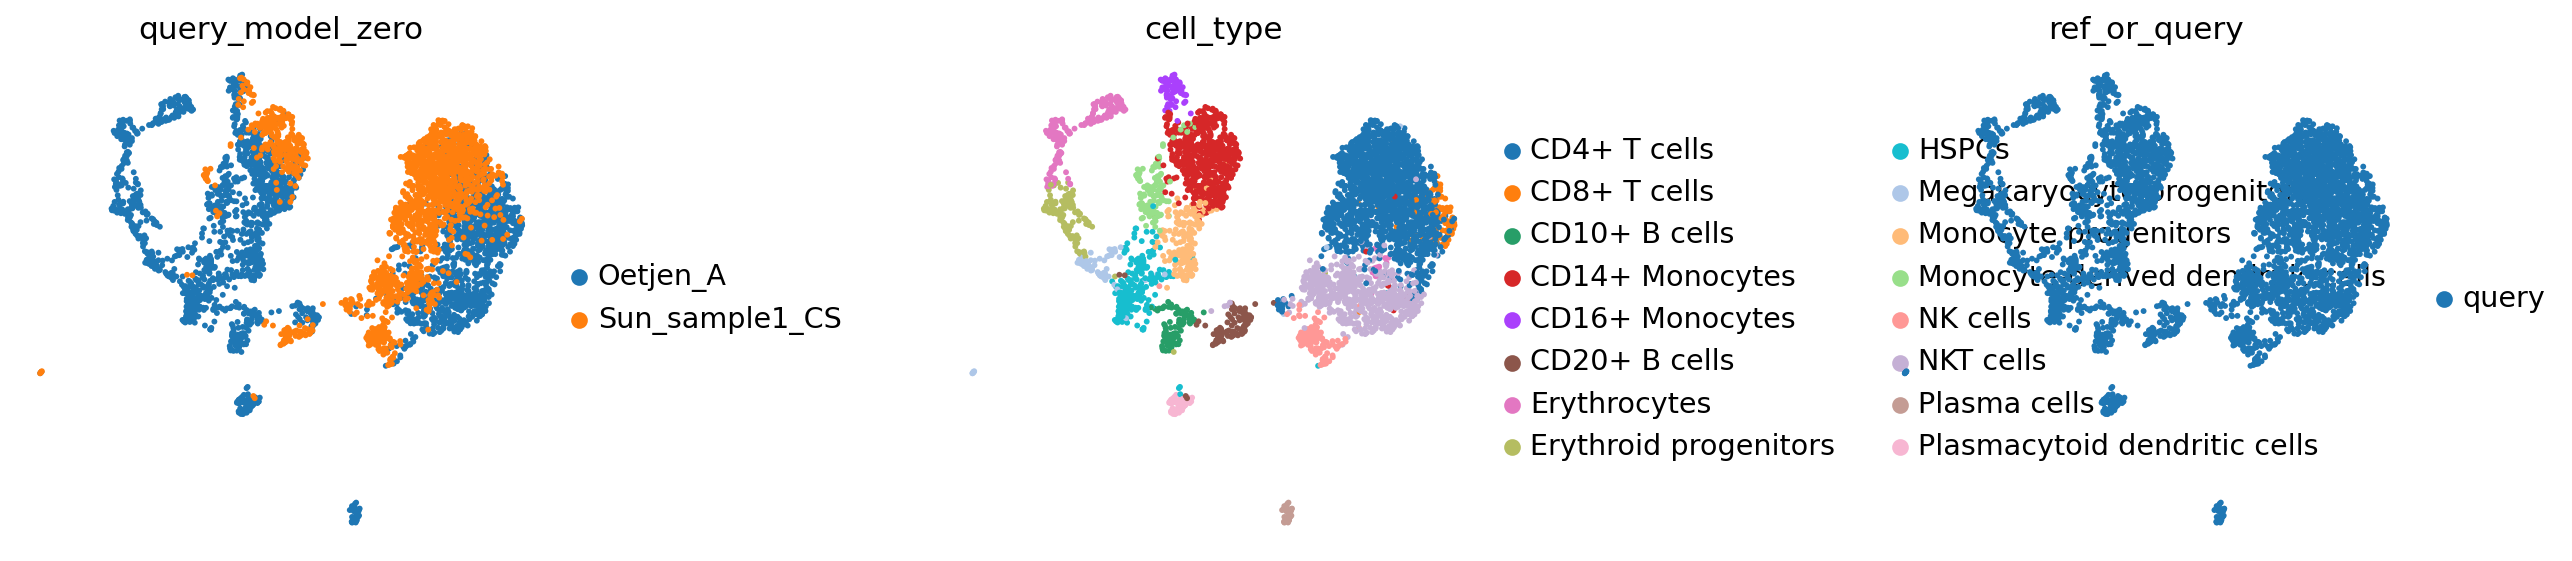

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


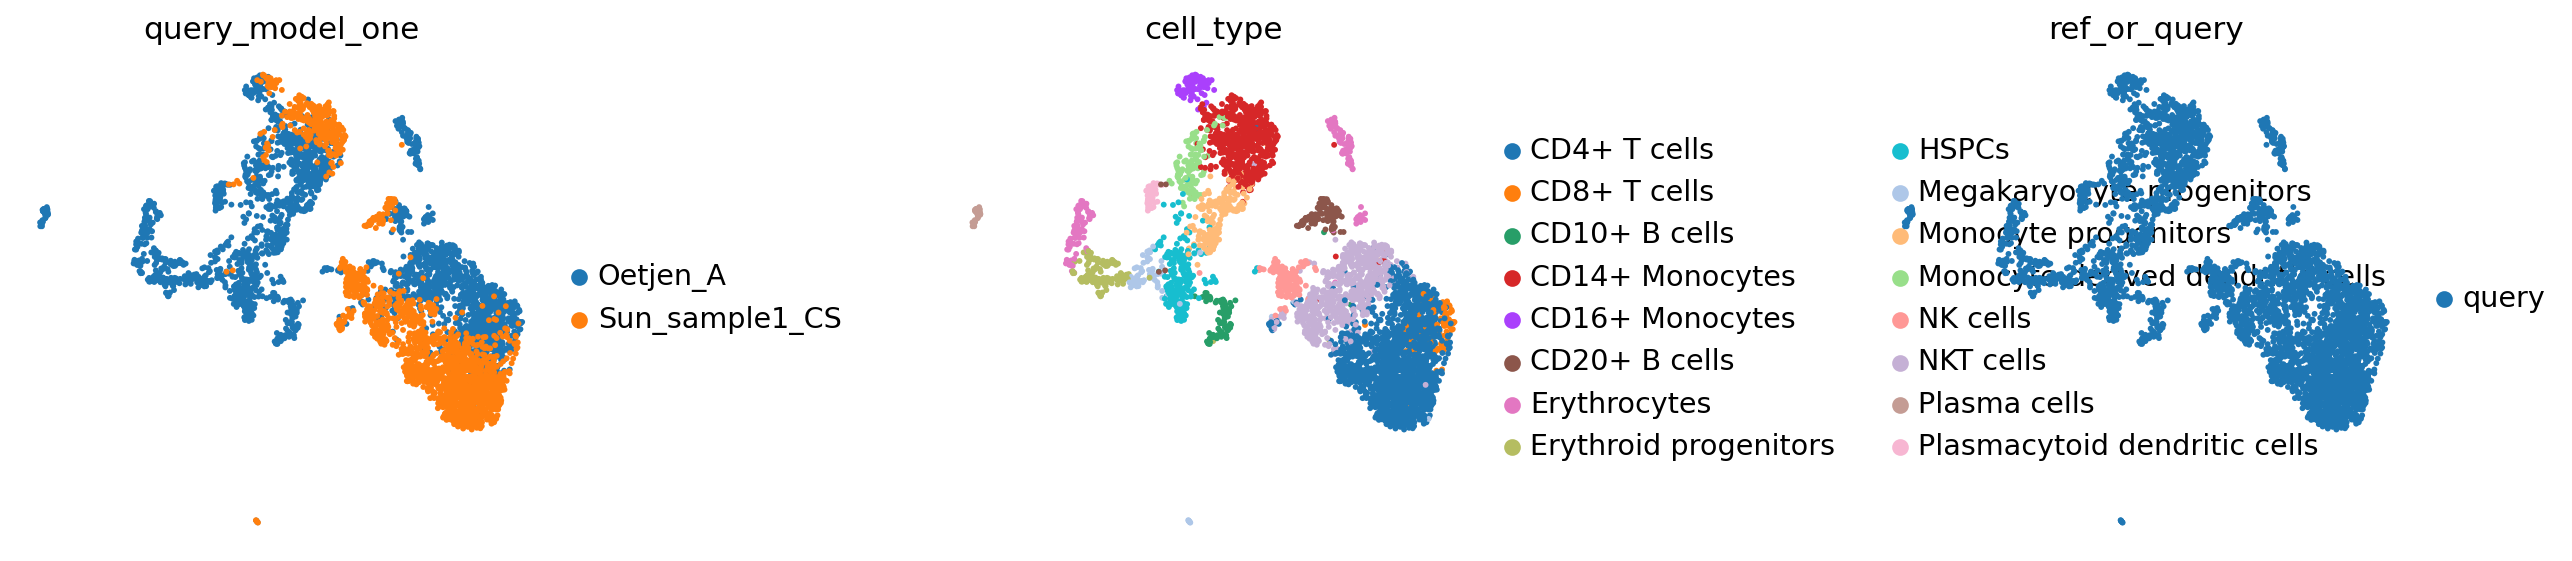

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


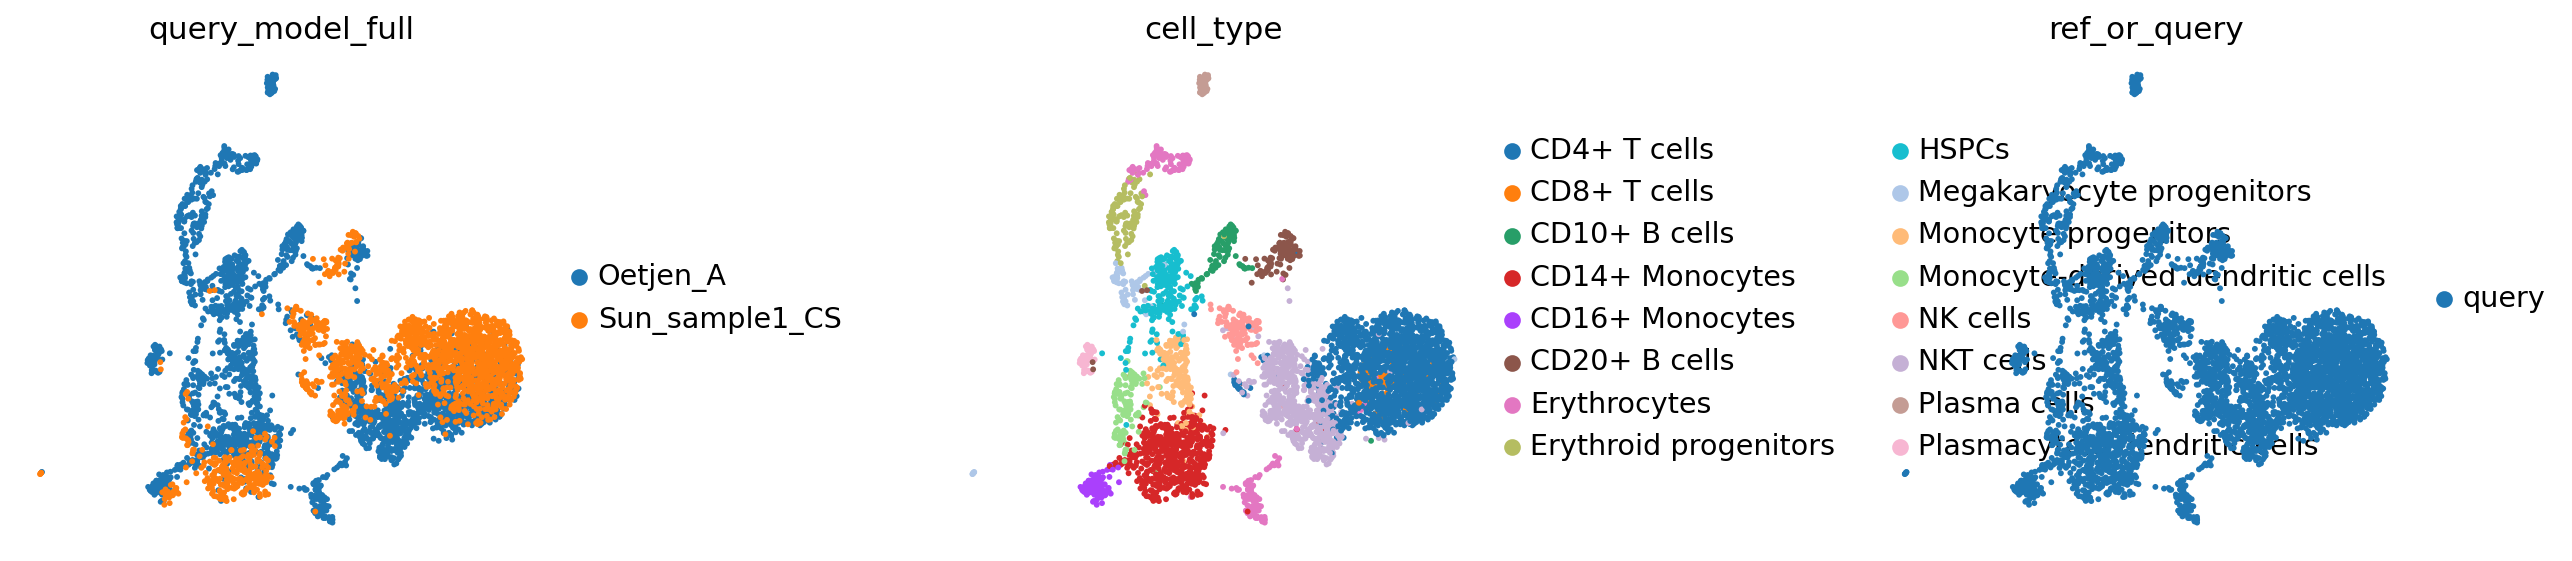

In [37]:
for i in range(len(adata_latent_array)):
    sc.pp.neighbors(adata_latent_array[i], n_neighbors=8)
    sc.tl.leiden(adata_latent_array[i])
    sc.tl.umap(adata_latent_array[i])
    sc.pl.umap(adata_latent_array[i],
           color=['batch', 'cell_type', 'ref_or_query'],
           frameon=False,
           wspace=0.6,
           title = surg_path[i]
           )

In [38]:
for j in range(len(models)):
    models[j].save(surg_path[j], overwrite=True)

### Get latent representation of reference + query dataset and compute UMAP

In [39]:
adata = adata[:, source_adata.var_names]
adata

View of AnnData object with n_obs × n_vars = 33506 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [40]:
full_latent_array = []

In [43]:
adata.obs['ref_or_query'] = np.where(adata.obs['batch'].isin(target_conditions), 'query', 'ref')

In [44]:
adata.obs.head()

batch chemistry data_type  dpt_pseudotime  \
index                                                                       
AAACCTGCAGCGAACA-1-Oetjen_A  Oetjen_A    v2_10X       UMI             NaN   
AAACCTGCATGTCCTC-1-Oetjen_A  Oetjen_A    v2_10X       UMI             NaN   
AAACCTGGTCGACTGC-1-Oetjen_A  Oetjen_A    v2_10X       UMI             NaN   
AAACCTGGTCGCTTCT-1-Oetjen_A  Oetjen_A    v2_10X       UMI             NaN   
AAACCTGTCCCGACTT-1-Oetjen_A  Oetjen_A    v2_10X       UMI             NaN   

                            final_annotation   mt_frac  n_counts  n_genes  \
index                                                                       
AAACCTGCAGCGAACA-1-Oetjen_A  CD16+ Monocytes  0.047970    6379.0   1862.0   
AAACCTGCATGTCCTC-1-Oetjen_A     CD4+ T cells  0.024928    4172.0   1082.0   
AAACCTGGTCGACTGC-1-Oetjen_A  CD14+ Monocytes  0.051907    6608.0   1618.0   
AAACCTGGTCGCTTCT-1-Oetjen_A  CD14+ Monocytes  0.041716    5034.0   1413.0   
AAACCTGTCCCGACTT-1-Oetjen_A        NKT cells  0.043522    3998.0   1127.0   

                            sample_ID  size_factors species   study  \
index                                                                 
AAACCTGCAGCGAACA-1-Oetjen_A         0      0.957719   Human  Oetjen   
AAACCTGCATGTCCTC-1-Oetjen_A         0      0.425532   Human  Oetjen   
AAACCTGGTCGACTGC-1-Oetjen_A         0      0.773111   Human  Oetjen   
AAACCTGGTCGCTTCT-1-Oetjen_A         0      0.641188   Human  Oetjen   
AAACCTGTCCCGACTT-1-Oetjen_A         0      0.452426   Human  Oetjen   

                                  tissue ref_or_query  
index                                                  
AAACCTGCAGCGAACA-1-Oetjen_A  Bone_Marrow        query  
AAACCTGCATGTCCTC-1-Oetjen_A  Bone_Marrow        query  
AAACCTGGTCGACTGC-1-Oetjen_A  Bone_Marrow        query  
AAACCTGGTCGCTTCT-1-Oetjen_A  Bone_Marrow        query  
AAACCTGTCCCGACTT-1-Oetjen_A  Bone_Marrow        query

In [45]:
for model in models:
    full_latent = sc.AnnData(model.get_latent(adata.X, adata.obs[condition_key]))
    full_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
    full_latent.obs['batch'] = adata.obs[condition_key].tolist()
    full_latent.obs['ref_or_query'] = adata.obs['ref_or_query'].tolist()
    full_latent_array.append(full_latent)

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


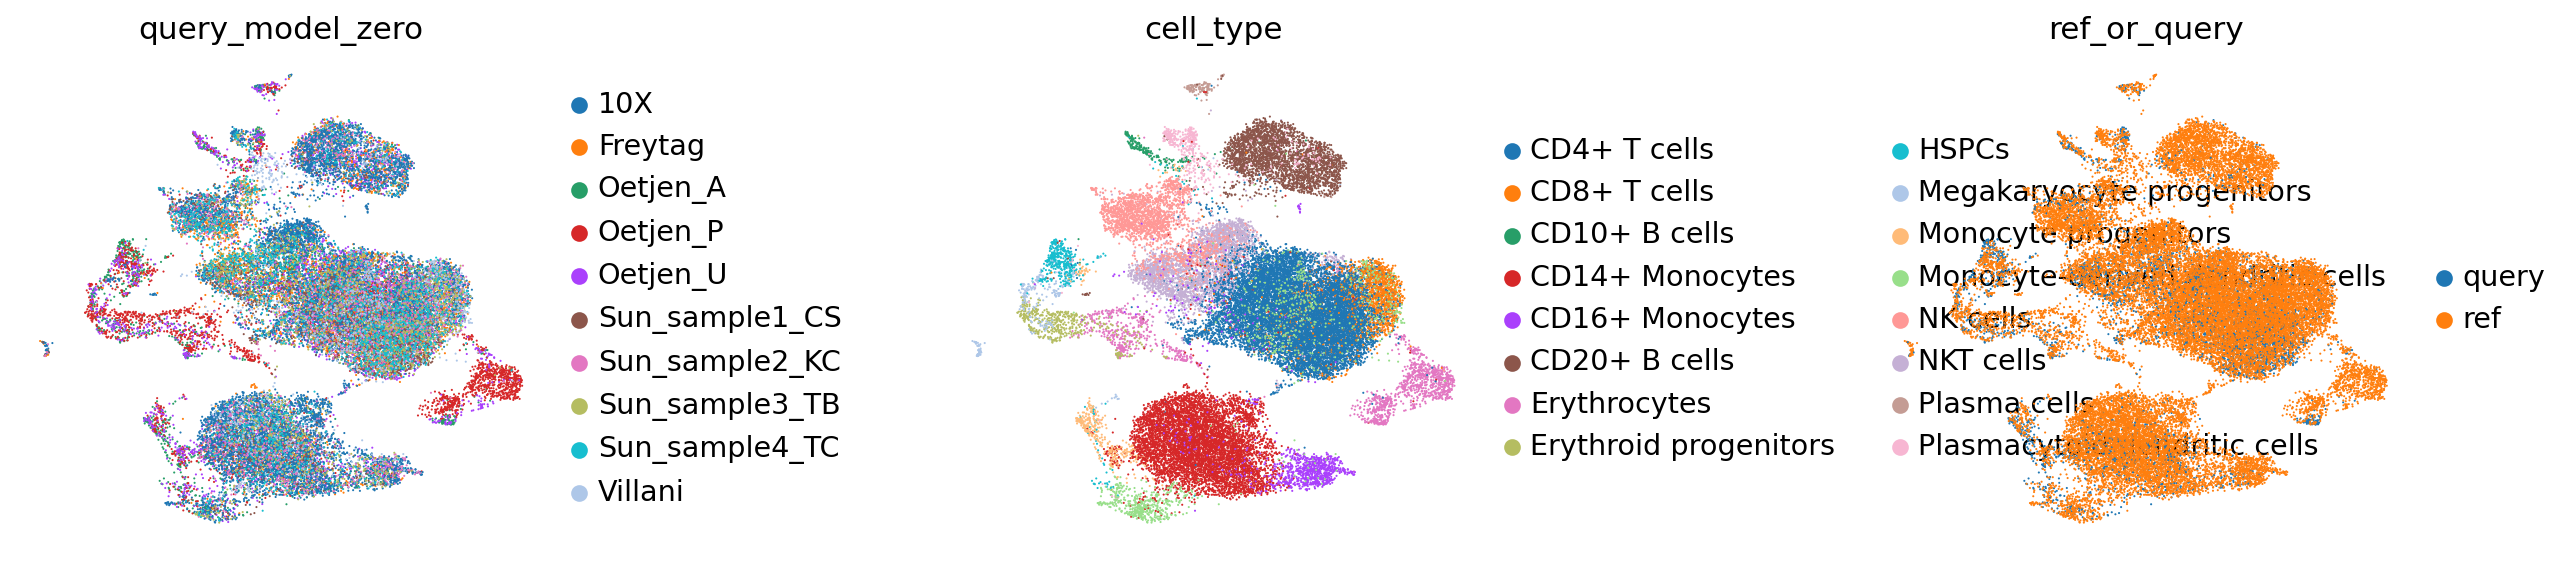

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


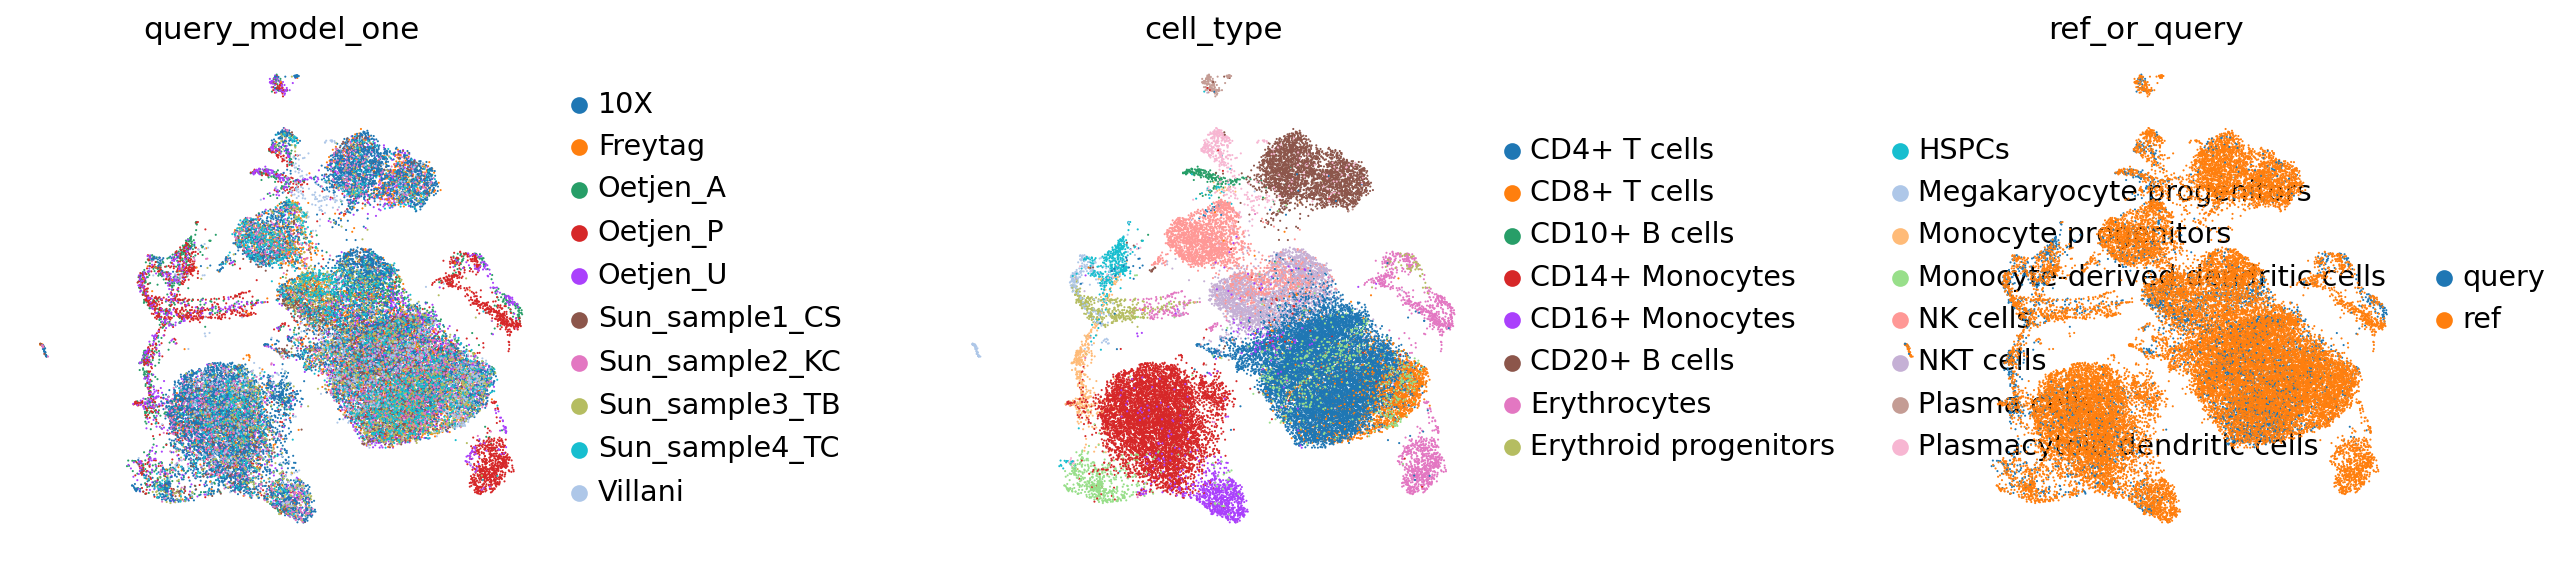

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


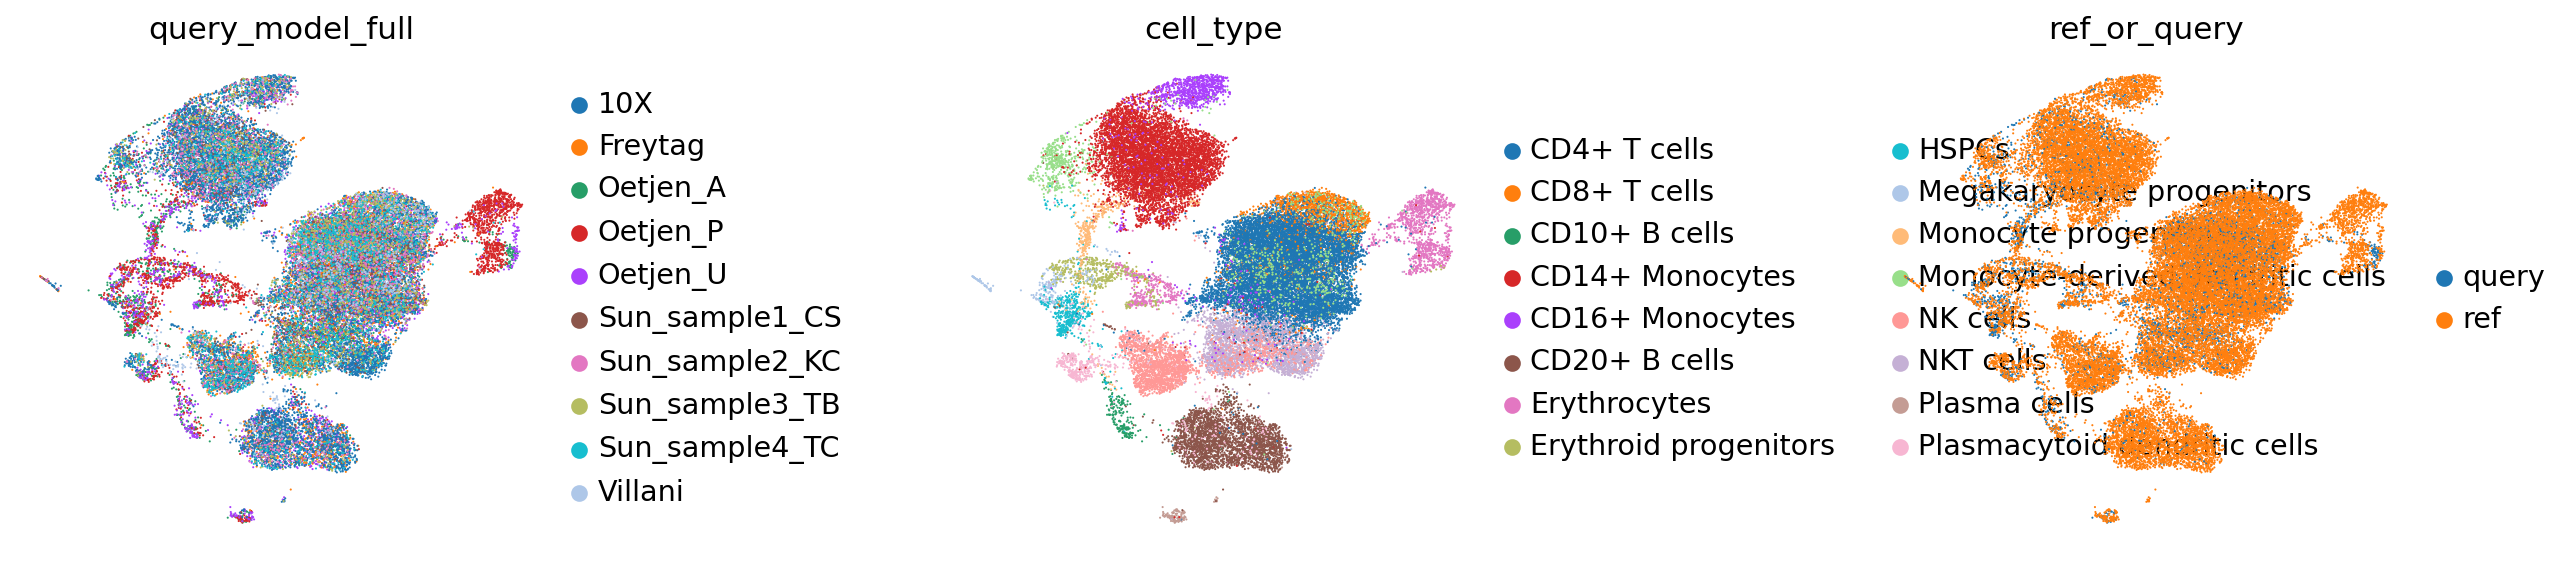

In [46]:
for i in range(len(full_latent_array)):
    sc.pp.neighbors(full_latent_array[i], n_neighbors=8)
    sc.tl.leiden(full_latent_array[i])
    sc.tl.umap(full_latent_array[i])
    sc.pl.umap(full_latent_array[i],
           color=['batch', 'cell_type','ref_or_query'],
           frameon=False,
           wspace=0.6,
           title = surg_path[i]
           )

## Benchmarking for Biological Conservation and Batch Correction

In [47]:
results_array = []

In [48]:
full_latent_array

[AnnData object with n_obs × n_vars = 33506 × 10
     obs: 'cell_type', 'batch', 'ref_or_query', 'leiden'
     uns: 'neighbors', 'leiden', 'umap', 'batch_colors', 'cell_type_colors', 'ref_or_query_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 33506 × 10
     obs: 'cell_type', 'batch', 'ref_or_query', 'leiden'
     uns: 'neighbors', 'leiden', 'umap', 'batch_colors', 'cell_type_colors', 'ref_or_query_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 33506 × 10
     obs: 'cell_type', 'batch', 'ref_or_query', 'leiden'
     uns: 'neighbors', 'leiden', 'umap', 'batch_colors', 'cell_type_colors', 'ref_or_query_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities']

In [49]:
adata.obs['cell_type'] = adata.obs['final_annotation']

In [50]:
for i in range(len(full_latent_array)):
    results = scib.metrics.metrics(
        adata, full_latent_array[i],
        batch_key= 'batch',label_key = 'cell_type', organism= 'human', subsample=1., embed = 'X_umap',
        graph_conn_=True, nmi_ = True, ari_ = True,
        ilisi_=False, isolated_labels_asw_= True, cell_cycle_= True,
        silhouette_=True
    )
    results_array.append(results)

NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...
NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...
NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...


In [51]:
def median_bio_conserv(results):
    column = results[0]
    return (column.iloc[0] + column.iloc[1] + column.iloc[2] + column.iloc[4])/4

In [52]:
def median_batch_corr(results):
    column = results[0]
    return (column.iloc[3] + column.iloc[5] + column.iloc[6])/3

# Results

In [53]:
results_zero = results_array[0].dropna()


In [54]:
print('Zero shot: ')
print(f"bio_conservation = {median_bio_conserv(results=results_zero)}")
print(f"batch_correction = {median_batch_corr(results=results_zero)}")
results_zero

Zero shot: 
bio_conservation = 0.6579596273661558
batch_correction = 0.7501964232766182


0
NMI_cluster/label          0.751555
ARI_cluster/label          0.717945
ASW_label                  0.577631
ASW_label/batch            0.718081
cell_cycle_conservation    0.584708
isolated_label_silhouette  0.583869
graph_conn                 0.948640

In [55]:
results_one = results_array[1].dropna()

In [56]:
print('One shot: ')
print(f"batch_correction = {median_bio_conserv(results=results_one)}")
print(f"batch_correction = {median_batch_corr(results=results_one)}")
results_one

One shot: 
batch_correction = 0.6431810939122937
batch_correction = 0.7500113083710902


0
NMI_cluster/label          0.744219
ARI_cluster/label          0.715963
ASW_label                  0.570341
ASW_label/batch            0.736490
cell_cycle_conservation    0.542202
isolated_label_silhouette  0.580104
graph_conn                 0.933440

In [57]:
results_full = results_array[2].dropna()

In [58]:
print('Full query: ')
print(f"bio_conservation = {median_bio_conserv(results=results_full)}")
print(f"batch_correction = {median_batch_corr(results=results_full)}")
results_full

Full query: 
bio_conservation = 0.6218719456676842
batch_correction = 0.7364227567121158


0
NMI_cluster/label          0.744901
ARI_cluster/label          0.713699
ASW_label                  0.576800
ASW_label/batch            0.712753
cell_cycle_conservation    0.452087
isolated_label_silhouette  0.560954
graph_conn                 0.935561